# MNIST

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal, Empirical
import edward as ed
import pandas as pd
ed.set_seed(314159)

Use the TensorFlow method to download and/or load the data

In [2]:
mnist = input_data.read_data_sets("MNIST_data2/",reshape=False,one_hot = True)

Extracting MNIST_data2/train-images-idx3-ubyte.gz
Extracting MNIST_data2/train-labels-idx1-ubyte.gz
Extracting MNIST_data2/t10k-images-idx3-ubyte.gz
Extracting MNIST_data2/t10k-labels-idx1-ubyte.gz


Task is to classify the handwritten MNIST digits into one of the classes {0,1,2,...,9} and give a measure of the uncertainty of our classification. 
* Our machine learning model will be a simple soft-max regression, and for this we first need to choose a likelihood function to quantify the probability of the observed data given a set of parameters (weights and biases in our case). 

* We will use a Categorical likelihood function (see Chapter 2, Machine Learning: a Probabilistic Perspective by Kevin Murphy for a detailed description of Categorical distribution, also called Multinoulli distribution.).


We next set up some placeholder variables in TensorFlow. 
* This follows the same procedure as you would for a standard neural network except that we use Edward to place priors on the weights and biases. 
* In the code below, we place a normal Gaussian prior on the weights and biases.

In [3]:
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
sess = tf.InteractiveSession(config=config)
# Initalize all the variables in the session
# tf.global_variables_initializer().run()
init = tf.global_variables_initializer()
sess.run(init)

In [4]:
# ed.set_seed(314159)
N = 64   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

In [5]:
mu = 0
sigma = 0.1
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
conv1_b = tf.Variable(tf.zeros(6))

conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))


fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))

fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))

fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(10))



def lenet_forward(x,conv1_W,conv2_W, fc1_W, fc2_W,
          fc3_W,conv1_b , conv2_b, fc1_b, fc2_b, fc3_b ):
        
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        fc0   = tf.contrib.layers.flatten(conv2)
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        return logits
def lenet_forward2(x,conv1_W,conv2_W,conv1_b , conv2_b ):
        
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        fc0   = tf.contrib.layers.flatten(conv2)
        return fc0
        
def lenet_forward3(x,fc1_W, fc2_W,
          fc3_W, fc1_b, fc2_b, fc3_b ):
        
        fc1   = tf.matmul(x, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        return logits

x = tf.placeholder(tf.float32,shape=[None,28,28,1])
y = tf.placeholder(tf.int32, (None))
logits = lenet_forward(x,conv1_W,conv2_W, fc1_W, fc2_W,
          fc3_W,conv1_b , conv2_b, fc1_b, fc2_b, fc3_b)
y_ph = tf.one_hot(y, 10)
    

In [6]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= y_ph)
loss_operation = tf.reduce_mean(cross_entropy)
initial_lr = 0.01
k = 0.75
decay_rate = 0.0005
step = tf.Variable(0, trainable=False)

learning_rate = tf.train.inverse_time_decay(initial_lr,
                                            step,
                                           k,
                                           decay_rate)


optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
train_op = optimizer.minimize(loss_operation,
                             global_step=step)



correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_ph, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [7]:
# sess = tf.InteractiveSession()
# Initalize all the variables in the session
# tf.global_variables_initializer().run()
init = tf.global_variables_initializer()
sess.run(init)

In [8]:
# load entire test set

# Tensorflow method gives the label data in a hot vector format. WE convert to single label.


In [9]:
#100 epochs
# training_operation = optimizer.minimize(loss_operation)
for i in range(10000):
    X_batch, Y_batch = mnist.train.next_batch(64)
    X_test, Y_test = mnist.test.next_batch(64)
#     X_batch_test, Y_batch_test = mnist.test.images
    # Tensorflow method, gives the label data in a one hot vector format.
    # We convert taht into a single label
#     Y_batch = np.argmax(Y_batch, axis=1)
    res = sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})

    if i%1000==0:
#         res = sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
        print(accuracy_operation.eval(feed_dict={x: X_test, y_ph: Y_test}))


0.109375
0.984375
0.984375
1.0
1.0
0.921875
1.0
1.0
0.984375
1.0


# LeNet Accuracy after 25k batches

In [10]:
print(accuracy_operation.eval(feed_dict={x: X_test, y_ph: Y_test}))


0.984375


In [11]:
a = conv1_W.eval()
b = conv1_b.eval()
c = conv2_W.eval()
d = conv2_b.eval()
# print tf.zeros([5,5]), a.shape

In [12]:
# # Define LeNet weights for SGHMC


x2 = tf.placeholder(tf.float32,[None,256])
fc1_W = Normal(loc=tf.zeros([256, 120]), scale = tf.ones([256, 120]))
fc1_b= Normal(loc=tf.zeros(120), scale = tf.ones(120))

# fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
# fc2_b  = tf.Variable(tf.zeros(84))

fc2_W = Normal(loc=tf.zeros([120, 84]), scale = tf.ones([120, 84]))
fc2_b= Normal(loc=tf.zeros(84), scale = tf.ones(84))

# fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
# fc3_b  = tf.Variable(tf.zeros(10))

fc3_W = Normal(loc=tf.zeros([84, 10]), scale = tf.ones([84, 10]))
fc3_b= Normal(loc=tf.zeros(10), scale = tf.ones(10))

In [13]:

y2 = Categorical(lenet_forward3(x2,fc1_W, fc2_W,
          fc3_W, fc1_b, fc2_b, fc3_b ))

In [14]:

# T = 25000 #30 epochs at 64 batch size
# T= 78125 #100 epochs at 64 batch size
T= 30000 #100+ epochs at 64 batch size

qconv1_W = Empirical(params=tf.Variable(tf.zeros([T,5, 5, 1, 6])))

qconv1_b = Empirical(params=tf.Variable(tf.zeros([T,6])))
                  

qconv2_W = Empirical(params=tf.Variable(tf.zeros([T,5, 5, 6, 16])))
qconv2_b = Empirical(params=tf.Variable(tf.zeros([T,16])))


qfc1_W = Empirical(params=tf.Variable(tf.random_normal([T,256,120])))
            
qfc1_b = Empirical(params=tf.Variable(tf.random_normal([T,120])))


qfc2_W  = Empirical(params=tf.Variable(tf.random_normal([T,120,84])))
                                  
qfc2_b  =  Empirical(params=tf.Variable(tf.random_normal([T,84])))



qfc3_W  = Empirical(params=tf.Variable(tf.random_normal([T,84,10])))
qfc3_b  = Empirical(params=tf.Variable(tf.random_normal([T,10])))




Up to this point we have defined the likelihood P(y|x,;ω)P(y|x,;ω) and the prior P(ω)P(ω), next we want to use Bayes rule to compute the posterior P(ω|y,x)P(ω|y,x)

However, we immediately face a problem because in practice the probability of the outputs P(y)P(y) is computationally intractable to compute for large instances and so we don't attempt to calculate the posterior directly.

To tackle this problem we will instead be using Variational Inference (VI). In Variational Inference we choose a family of parameterised distributions Q(ω;λ)Q(ω;λ) over parameters ωω to approximate the true posterior, and then optimize the parameters λλ so as to match the true posterior distribution as best as possible. The core idea is to minimise what is known as the Kullback-Leibler divergence between the true posterior P(ω|y,x)P(ω|y,x) and the approximating ditribution Q(ω;λ)Q(ω;λ), which can be thought of as a measure of the disimilarity between two probability distributions.


The theory behind VI is beyond the scope of this blog, so more more information a quick introduction to VI can be found in Edward's documentation and a detailed one in Variational Inference: A Review for Statisticians by Blei et al.. Chapter 33 or MacKay's book is also a very good reference.

So next we use Edward to set up the approximating distributions Qw(ω)Qw(ω) for the weights and Qb(ω)Qb(ω) for the biases:

In [15]:
# We use a placeholder for the labels in anticipation of the training data
conv1_W = tf.Variable(tf.constant(a), name="w")
conv1_b = tf.Variable(tf.constant(b),name="b")

conv2_W = tf.Variable(tf.constant(c),name="w2")
conv2_b = tf.Variable(tf.constant(d),name="b2")

x2 = tf.placeholder(tf.float32,[None,256],name="x")


y2 = Categorical(lenet_forward3(x2,fc1_W, fc2_W,
          fc3_W, fc1_b, fc2_b, fc3_b ), name="y")

# Note: batch size is 128
y_ph = tf.placeholder(tf.int32, [64])
x_ph = tf.placeholder(tf.float32, [256])
# Define the VI inference technique, ie. minimize the KL divergence between q and p
inference = ed.SGHMC({
fc1_W:qfc1_W,
fc1_b:qfc1_b,
fc2_W:qfc2_W,
fc2_b:qfc2_b,
fc3_W:qfc3_W,
fc3_b:qfc3_b}, data={y2:y_ph})

In [16]:
###### Initalize the inference variables
# Q: what does this do?!
'''FOR SGHMC'''
# inference.initialize(n_iter=5000, n_print=100,step_size=0.4e-5, friction=0.01)
# 1-friction= momentum
inference.initialize(n_iter=5000, n_print=100,step_size=0.8e-5)

# '''FOR KL'''
# inference.initialize(n_iter=1000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

 Now we are ready to perform Variational Inference. 
 We load up a TensorFlow session and start the iterations. Will take a few minutes.

In [17]:
#### tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
# We will use an interactive session
sess = tf.InteractiveSession(config=config)
# Initalize all the variables in the session
tf.global_variables_initializer().run()

In [18]:
X_tr = mnist.train.images
# Tensorflow method gives the label data in a hot vector format. WE convert to single label.
Y_tr = np.argmax(mnist.train.labels,axis=1)
X_2_tr=lenet_forward2(X_tr,conv1_W,conv2_W,conv1_b , conv2_b ).eval()

In [19]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [20]:
# Train model. 
# We load data in minibatches and update the VI inference using each new batch
for _ in range(inference.n_iter):
    X_batch_tr, Y_batch_tr = next_batch(64,X_2_tr,Y_tr)# preprocess image to fc layers

#     Y_batch = np.argmax(Y_batch_tr, axis=1)
    info_dict = inference.update(feed_dict={x2: X_batch_tr, y_ph: Y_batch_tr})
    inference.print_progress(info_dict)

30000/30000 [100%] ██████████████████████████████ Elapsed: 241s | Acceptance Rate: 1.000


# Evaluate Model

We now have everything that we need to run our model on the test data, let's see how good our model is! 

The major difference in Bayesian model evaluation is that there is no single value for the weights and biases that we should use to evaluate the model.

 Instead we should use the distribution of weights and biases in our model so that the uncertainties in these parameters are reflected in the final prediction.

Thus instead of a single prediction we get a set of predictions and their accuracies.

We draw a 100 samples from the posterior distribution and see how we perform on each of these samples. Taking samples be might a slow process, may take few seconds!

In [21]:
# Load test images
X_test = mnist.test.images
# Tensorflow method gives the label data in a hot vector format. WE convert to single label.
Y_test = np.argmax(mnist.test.labels,axis=1)
X_2_test=lenet_forward2(X_test,conv1_W,conv2_W,conv1_b , conv2_b ).eval()

In [22]:
# Generate samples the posterior and store them
n_samples = 100
prob_lst = []
samples = []
conv1_W_samples = []
conv1_b_samples = []
conv2_W_samples = []
conv2_b_samples = []
fc1_W_samples = []
fc1_b_samples = []
fc2_W_samples = []
fc2_b_samples = []
fc3_W_samples = []
fc3_b_samples = []
for i in range(100):
    if i%10==0:
        print i
    
#     conv1_W_samp = qconv1_W.sample()
#     conv1_b_samp=qconv1_b.sample()
#     conv2_W_samp = qconv2_W.sample()
#     conv2_b_samp = qconv2_b.sample()
    fc1_W_samp = qfc1_W.sample()
    fc1_b_samp = qfc1_b.sample()
    fc2_W_samp= qfc2_W.sample()
    fc2_b_samp = qfc2_b.sample()
    fc3_W_samp = qfc3_W.sample()
    fc3_b_samp = qfc3_b.sample()
    
    
    
#     conv1_W_samples.append(conv1_W_samp)
#     conv1_b_samples.append(conv1_b_samp)
#     conv2_W_samples.append(conv2_W_samp)
#     conv2_b_samples.append(conv2_b_samp)
    fc1_W_samples.append(fc1_W_samp)
    fc1_b_samples.append(fc1_b_samp)
    fc2_W_samples.append(fc2_W_samp)
    fc2_b_samples.append(fc2_b_samp)
    fc3_W_samples.append(fc3_W_samp)
    fc3_b_samples.append(fc3_b_samp)
    
    # Also compute the probability of each class for each (w,b) sample.
#     h = tf.nn.softmax(tf.matmul(X_test,w_samp) + b_samp)
    prob= lenet_forward3(X_2_test,fc1_W_samp, fc2_W_samp,
          fc3_W_samp, fc1_b_samp, fc2_b_samp, fc3_b_samp )
#     print prob
    
    prob_lst.append(prob.eval())
#     w_samp_reshape = tf.reshape(w_samp,[-1])
#     sample = tf.concat([w_samp_reshape,b_samp],0)
#     samples.append(sample.eval())

0
10
20
30
40
50
60
70
80
90


In [23]:
# Compute the accuracy of the model.

accy_test = []
for prob in prob_lst:
    # For each sample we compute the predicted class and compare with the test labels
    y_trn_prd = np.argmax(prob, axis=1).astype(np.float32)
    # Predicted class is defined as the one which has maximum probability
    # We preform this test for each (w,b) in the posterior giving us a set of accuracies
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

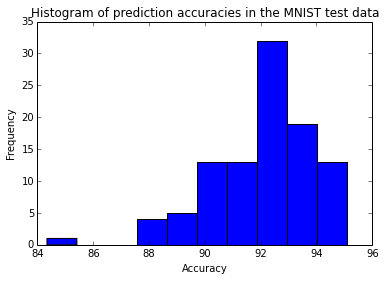

In [24]:
# Finally we make a histogram of accuracies for the test data.
plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

In [25]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

('accuracy in predicting the test data = ', 95.260000000000005)


# MC Dropout

In [26]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
# Initalize all the variables in the session
# tf.global_variables_initializer().run()
init = tf.global_variables_initializer()
sess.run(init)

In [27]:
# ed.set_seed(314159)
N = 64   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

In [28]:
mu = 0
sigma = 0.1
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
conv1_b = tf.Variable(tf.zeros(6))

conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))


fc1_W = tf.Variable(tf.truncated_normal(shape=(256, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))

fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))

fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(10))



def lenet_forward(x,conv1_W,conv2_W, fc1_W, fc2_W,
          fc3_W,conv1_b , conv2_b, fc1_b, fc2_b, fc3_b ):
        
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        conv1 = tf.nn.dropout(conv1,keep_prob=0.5)
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        conv2 = tf.nn.dropout(conv2,keep_prob=0.5)

        fc0   = tf.contrib.layers.flatten(conv2)
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1,keep_prob=0.5)
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2,keep_prob=0.5)
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        return logits
def lenet_forward2(x,conv1_W,conv2_W,conv1_b , conv2_b ):
        
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        conv1 = tf.nn.dropout(conv1,keep_prob=0.5,)
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        conv2 = tf.nn.dropout(conv2,keep_prob=0.5)
        
        fc0   = tf.contrib.layers.flatten(conv2)
        return fc0
        
def lenet_forward3(x,fc1_W, fc2_W,
          fc3_W, fc1_b, fc2_b, fc3_b ):
        
        fc1   = tf.matmul(x, fc1_W) + fc1_b
        fc1    = tf.nn.relu(fc1)
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b
        fc2    = tf.nn.relu(fc2)
        logits = tf.matmul(fc2, fc3_W) + fc3_b
        
        return logits

x = tf.placeholder(tf.float32,shape=[None,28,28,1])
y = tf.placeholder(tf.int32, (None))
logits = lenet_forward(x,conv1_W,conv2_W, fc1_W, fc2_W,
          fc3_W,conv1_b , conv2_b, fc1_b, fc2_b, fc3_b)
y_ph = tf.one_hot(y, 10)
    

In [29]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= y_ph)
loss_operation = tf.reduce_mean(cross_entropy)
initial_lr = 0.01
k = 0.75
decay_rate = 0.0005
step = tf.Variable(0, trainable=False)

learning_rate = tf.train.inverse_time_decay(initial_lr,
                                            step,
                                           k,
                                           decay_rate)


optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
train_op = optimizer.minimize(loss_operation,
                             global_step=step)


correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_ph, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [30]:
sess = tf.InteractiveSession()
# Initalize all the variables in the session
# tf.global_variables_initializer().run()
init = tf.global_variables_initializer()
sess.run(init)

In [31]:
# Load entire test set
# X_batch_test, Y_batch_test = mnist.test.next_batch(10000)

In [32]:
#100 epochs
# training_operation = optimizer.minimize(loss_operation)
for i in range(10000):
    X_batch, Y_batch = mnist.train.next_batch(64)
    X_batch_test, Y_batch_test = mnist.test.next_batch(64)
    # Tensorflow method, gives the label data in a one hot vector format.
    # We convert taht into a single label
#     Y_batch = np.argmax(Y_batch, axis=1)
    res = sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})

    if i%1000==0:
        print(accuracy_operation.eval(feed_dict={x: X_batch_test, y_ph: Y_batch_test}))


0.109375
0.578125
0.640625
0.703125
0.765625
0.78125
0.828125
0.8125
0.921875
0.875


# LeNet with all parameter layers having dropout

In [33]:

print(accuracy_operation.eval(feed_dict={x: X_batch_test, y_ph: Y_batch_test}))


0.859375


In [34]:
x_samples, y_samples = mnist.test.next_batch(100)
x_sample_tensor = tf.Variable(tf.constant(x_samples),name="test")
y_sample_tensor = tf.Variable(tf.constant(y_samples),name="test")

In [35]:
init_new_vars_op = tf.initialize_variables([x_sample_tensor, y_sample_tensor])
sess.run(init_new_vars_op)

Instructions for updating:
Use `tf.variables_initializer` instead.


In [36]:
probs = []
for i in range(100):
    # set is_training = True if want dropout to be applied
    print i
    prob = lenet_forward(x_samples,conv1_W,conv2_W, fc1_W, fc2_W,
          fc3_W,conv1_b , conv2_b, fc1_b, fc2_b, fc3_b ).eval()
    probs+= [prob]
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [37]:
# mean 100 samples
print len(probs)
mean = np.mean(probs,axis=0)
print mean.shape
var = np.var(probs,axis=0)
print var.shape

100
(100, 10)
(100, 10)


# LeNet-MCDropout score

In [38]:
p = probs[:20]
print len(p)
m = np.mean(p,axis=0)
print m.shape

correct_prediction = tf.equal(tf.argmax(m, 1), tf.argmax(y_sample_tensor, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
acc_final = 1- accuracy_operation.eval()
print acc_final

20
(100, 10)
0.0699999928474


In [39]:
def get_classification_error(probs,i):
    # i is how many samples to average
    # makes it easy to get accuracy over 1,2,...,20,...100 samples
    mean = np.mean(probs[:i],axis=0)
    correct_prediction = tf.equal(tf.argmax(mean, 1), tf.argmax(y_sample_tensor, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return 1-accuracy_operation.eval()
1-get_classification_error(probs,20)

0.93000000715255737

In [40]:
mean_classification_error_over_samples = [get_classification_error(probs,i)for i in range(1,len(probs))]

## Here we show how the classification error decreases as you increase number of samples
Here we see that after 20 samples, we get effective classification that performs better than LeNet accuracy over entire test set. 

## ToDo(Yue): Add classification error of LeNet-SGHMC over number of samples

In [41]:
# mean_classification_error_over_samples = [get_classification_error(probs,i)for i in range(1,len(probs))]

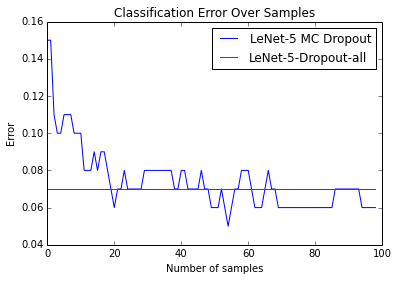

In [42]:
plt.plot(range(len(mean_classification_error_over_samples)),mean_classification_error_over_samples)
plt.plot(range(len(mean_classification_error_over_samples)),[acc_final for i in range(len(mean_classification_error_over_samples))])
plt.title("Classification Error Over Samples")
plt.xlabel("Number of samples")
plt.legend(["LeNet-5 MC Dropout","LeNet-5-Dropout-all"])
plt.ylabel("Error ")

In [43]:
var = [[np.mean(np.var(probs[:i],axis=0)[:,j]) for i in range(1,len(probs))] for j in range(10)]
print len(var[0])
print len(var[1])

99
99


In [44]:
np.mean(np.var(probs[:100],axis=0)[:,0])

10.462597

## The goal here is to show hopefully that the variance decreases as the number of samples increase (we can or dont have to place this in the result)

### We see that after 10 samples, the variance does not increase for all 10 classes. The variance is still large, but may not be that important as the CNN seems to handle variability well in the network. 
We can get some insight that digit 6 is the most challenging

## ToDo(Yue): Make another graph showing LeNet-SGHMC variance (per class) over number of samples
   ### I think we can show that SGHMC has less variance per class than MC Dropout


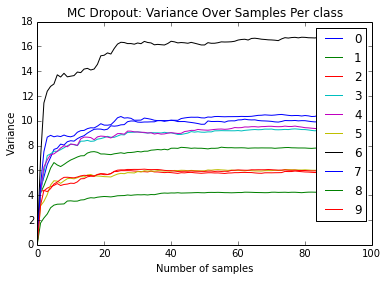

In [45]:
plt.plot(range(len(var[0])),var[0])
plt.plot(range(len(var[0])),var[1])
plt.plot(range(len(var[0])),var[2])
plt.plot(range(len(var[0])),var[3])
plt.plot(range(len(var[0])),var[4])
plt.plot(range(len(var[0])),var[5])
plt.plot(range(len(var[0])),var[6])
plt.plot(range(len(var[0])),var[7])
plt.plot(range(len(var[0])),var[8])
plt.plot(range(len(var[0])),var[9])
plt.title("MC Dropout: Variance Over Samples Per class")
plt.xlabel("Number of samples")
plt.ylabel("Variance ")
plt.legend(['0','1','2','3','4','5','6','7','8','9'])
plt.show()

In [46]:
def get_classification_variance(probs,i):
    # i is how many samples to average
    # makes it easy to get accuracy over 1,2,...,20,...100 samples
    var = np.var(probs[:i],axis=0)
    correct_prediction = tf.equal(tf.argmax(mean, 1), tf.argmax(y_sample_tensor, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return 1-accuracy_operation.eval()
1-get_classification_error(probs,20)

0.93000000715255737

In [47]:
plt.plot(range(4),[mean_2plt.title("Avg Classification Error Over Samples")
plt.xlabel("Number of samples")
plt.ylabel("Error ")5_samples,mean_50_samples,])

SyntaxError: invalid syntax (<ipython-input-47-9f8d18ef8dd2>, line 2)

# Accuracy of Bayes CNN after averaging 100 samples of entire test dataset

In [ ]:
# # logits.shape
# correct_prediction = tf.equal(tf.argmax(mean, 1), tf.argmax(y_sample_tensor, 1))
# accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# print accuracy_operation.eval()